# Earthquake detection

## Description

This example is about an earthquake detection using change point detection methods. 

We use data from [Global Seismogram Viewer (GSV)](http://ds.iris.edu/gsv) developed by the [Incorporated Research Institutions for Seismology (IRIS)](https://www.iris.edu/hq/). The viewer shows seismic wave arrivals for large earthquakes at seismic recording stations around the world. Scientists use the arrival times to identify the location of the earthquake, determine how deep it was, exactly when it occurred, and for other purposes. These seismic records also help to explore Earth’s inner structure, because the traveling waves bounce and diffract at different speeds and angles, depending on the density, solidity and other characteristics of the Earth.

In this example, we estimate seismic wave arrival using the change point detection technique. We consider an earthquake that occurred on March 11, 2011 near the east coast of Honshu in Japan, and has a magnitude of 9.1. A range of stations recorded the wave from this earthquake over the world. We took data from CASY station in Antarctica in 11825 km from the center of the earthquake. 

## Data download

We use [IRIS URL Builder Web Service](http://service.iris.edu/fdsnws/dataselect/docs/1/builder/) to download seismograms from the station. In this example, we use data in the BHZ channel, recorded with a sample rate of 20 Hz, and contains 216000 records for 3 hours. Run the following lines of code to download the data and unzip it. 

In [1]:
# !wget -O "fdsnws.zip" "http://service.iris.edu/fdsnws/dataselect/1/query?net=IU&sta=CASY&starttime=2011-03-11T05:00:00&endtime=2011-03-11T08:00:00&format=geocsv.zip"
# !unzip -o -q fdsnws.zip -d fdsnws

In [2]:
# import of basic libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import roerich

Now we read the data file. It contains metadata in the first 18 rows and two columns:

- **Time:** timestamps of measurements;
- **Sample:** seismometer measurements.

In [3]:
path = "fdsnws/IU.CASY.00.BHZ.M.2011-03-11T050000.024220.csv"

data = pd.read_csv(path, skiprows=18)
data.head()

,Time,Sample
0,2011-03-11T05:00:00.024220Z,2854
1,2011-03-11T05:00:00.074220Z,2804
2,2011-03-11T05:00:00.124220Z,2740
3,2011-03-11T05:00:00.174220Z,2668
4,2011-03-11T05:00:00.224220Z,2588


The file contains 216000 observations. We take only each 10th of them. It is enough for our exercise. Moreover, we manually found the seismic wave arrival time. The figure below shows a waveform of the signal.

In [4]:
# take only earch 10th observation
X = data[[' Sample']].values[::10]

# wave arrival manually determined
cps_true = [7350]

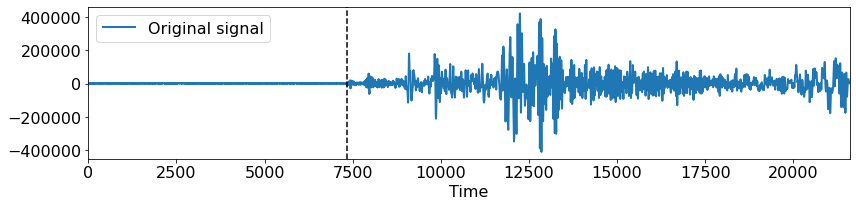

In [5]:
# visualization
roerich.display(X, cps_true, score=None, cps_pred=None)

## Preprocessing

As always, we preprocess the data. We scale it with `StandardScaler` and add some noise to the signal. It is optional, but sometimes it can be helpful. Moreover, adding noise is a regularization technique for change point detection methods. It helps to reduce the number of false alarms, for example.

In [6]:
from sklearn.preprocessing import StandardScaler

# scale the signal
ss = StandardScaler().fit(X)
X_ss = ss.transform(X)

# add noise for regularization
X_ss += np.random.normal(0, 0.01, X_ss.shape)

## Change point detection

We apply `ChangePointDetectionClassifier` method to identify the seismic wave arrival time. Here, we use `RandomForestClassifier` as a basic classifier. You can use any other binary classifier you like. The figures below show, that the change point score has several peaks. The highest one correspond to the arrival time. Others indicate changes in the seismic wave regimes.  

In [7]:
from roerich.algorithms import ChangePointDetectionClassifier
from sklearn.ensemble import RandomForestClassifier

# sklearn-like binary classifier
clf = RandomForestClassifier(n_estimators=10, max_depth=4)

# change points detection
cpd = ChangePointDetectionClassifier(base_classifier=clf, metric='KL_sym', periods=1, 
                                     window_size=1000, step=10, n_runs=1)
score, cps_pred = cpd.predict(X_ss)

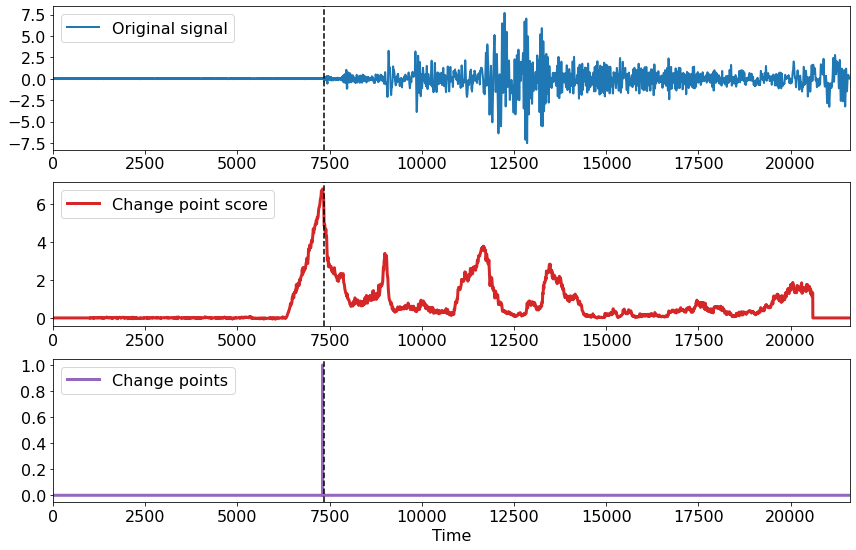

In [8]:
# take a CP with the highest score
cps_score = score[cps_pred]
cps_pred_max = cps_pred[cps_score.argmax()]

# visualization
roerich.display(X_ss, cps_true, score, cps_pred_max)

## Spectrogram

In the previous sections, we used the waveform. Now, let’s apply Fast Fourier Transform (FFT) to our signal to obtain its spectrogram. This technique is widely used in sound analysis and other signal processing tasks. To do this, we use `Spectrogram` from `torchaudio` library.

In [9]:
from torchaudio.transforms import Spectrogram
import torch

# define the spectrogram parameters
featurizer = Spectrogram(n_fft=64,
                         win_length=64,
                         hop_length=1, 
                         power=2, 
                         normalized=True)

def apply_compression(spec):
    return np.log(spec.clamp(1e-2))

In [10]:
# transform the waveform into spectrogram
spec = featurizer(torch.Tensor(X.reshape(-1,)))[:, :-1]
spec = apply_compression(spec)
spec.shape

torch.Size([33, 21600])

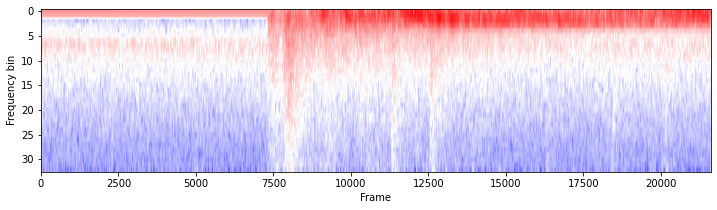

In [11]:
# display the spectrogram
plt.figure(figsize=(12, 3))
plt.imshow(spec, aspect='auto', cmap=cm.bwr)
plt.xlabel('Frame')
plt.ylabel('Frequency bin')
plt.show()

## Detection with spectrogram

Finally, we repeat all previous steps to find change points in the spectrogram. 

In [12]:
# spec into numpy array
XX = spec.T.numpy()

# scale the signal
ss = StandardScaler().fit(XX)
XX_ss = ss.transform(XX)

# add noise for regularization
XX_ss += np.random.normal(0, 0.1, XX_ss.shape)

In [13]:
# sklearn-like binary classifier
clf = RandomForestClassifier(n_estimators=10, max_depth=4)

# change points detection
cpd = ChangePointDetectionClassifier(base_classifier=clf, metric='KL_sym', periods=1, 
                                     window_size=1000, step=10, n_runs=1)
score, cps_pred = cpd.predict(XX_ss)

The figure shows that the results obtained based on the waveform and spectrogram are similar. The seismic wave arrival times are the same and have the highest scores.

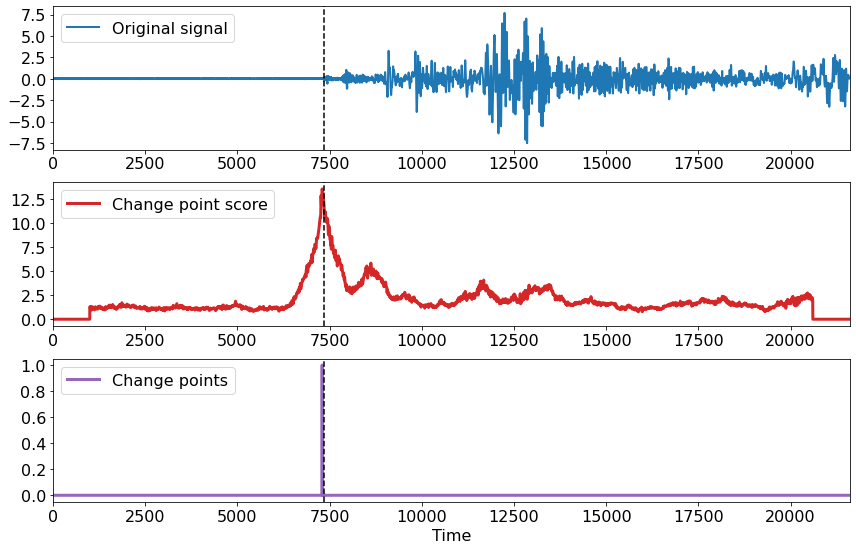

In [14]:
# take a CP with the highest score
cps_score = score[cps_pred]
cps_pred_max = cps_pred[cps_score.argmax()]

# visualization
roerich.display(X_ss, cps_true, score, cps_pred_max)

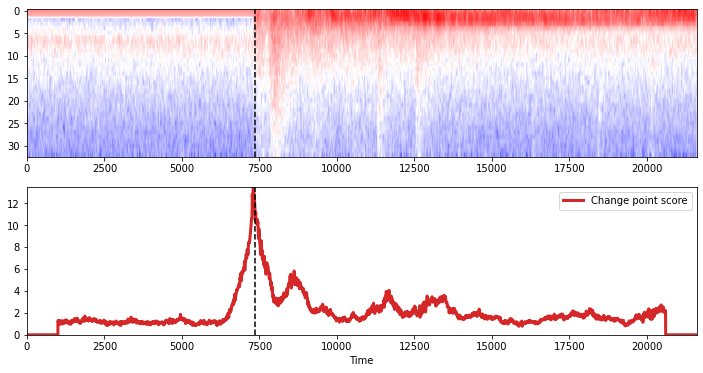

In [15]:
# plot spectrogram
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(spec, aspect='auto', cmap=cm.bwr)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(cps_true*2, [ymin, ymax], color='0', linestyle='--')

# plot change point score
plt.subplot(2, 1, 2)
plt.plot(score, linewidth=3, label="Change point score", color='C3')
plt.plot(cps_true*2, [score.min(), score.max()], color='0', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim([score.min(), score.max()])
plt.xlabel('Time')
plt.legend()
plt.show()